In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
%%capture
%load_ext jupyter_probcomp.magics
%matplotlib inline

## Plot the prior

Define the domain.

In [3]:
bound = 3 # we will compute the prior for both x and y from -bound to bound
n = 100 # Compute the prior for 100 x 100 values of x and y.
x_values = np.linspace(-bound, bound, n)
y_values = x_values # we want to plot a square.

Compute the prior over said domain.

In [4]:
prior = np.zeros((n, n)) # Initialize
for i, x_val in enumerate(x_values):
    for j, y_val in enumerate(x_values):
            # Compute the prior for x=x_val and y=y_val
            prior[i,j] = np.exp(norm.logpdf(x_val, loc=0, scale=1) + \
                                norm.logpdf(y_val, loc=0, scale=1))

In [5]:
colormap = 'plasma' # Define a colormap to plot prior and posterior.

#### Important: change the path to adapt to your system!

In [6]:
path = '/home/ulli/git_repos/Venture_semantics/figs/tutorial/'

In [7]:
fontsize = 15

In [8]:
# Create a simple contourplot in matplotlib
def plot_contours(probabilities):
    fig, ax = plt.subplots()
    contour_plot = ax.contourf(
        x_values,
        y_values, 
        probabilities, 
        cmap=colormap
    )
    fig.set_size_inches(4, 3)
    ax.set_xlabel('x', fontsize=fontsize)
    ax.set_ylabel('y', fontsize=fontsize)
    cbar = plt.colorbar(contour_plot)
    cbar.set_label('P(x, y)', fontsize=fontsize)
    return fig, ax

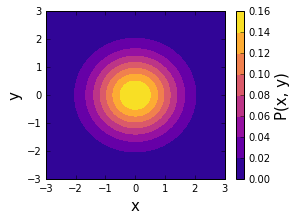

In [9]:
fig, ax = plot_contours(prior)
#ax.set_title('Prior for y and x', fontsize=fontsize);
###fig.savefig(path + 'prior.pdf', bbox_inches='tight')

## Venture code

In [10]:
%ripl --seed 42

Set seed of a new VentureScript RIPL to 42.00.


In [11]:
%%venturescript
assume x = normal(0, 1) #latent:"x";
assume y = normal(0, 1) #latent:"y";
assume obs_std = 1;
assume z = normal(x + y, obs_std);

In [12]:
%%venturescript
observe z = 3;

### Compute posterior analytically

In [13]:
# Ensure to use the correct observation in the analytical computation.
z = %venturescript sample z
# Ensure to use the correct observation-noise in the analytical computation.
obs_std = %venturescript sample obs_std
# Initialize posterior
posterior = np.zeros((n, n))
for i, i_val in enumerate(x_values):
    for j, j_val in enumerate(y_values):
            # Compute the posterior at a given set of values x and y.
            posterior[i,j] = np.exp(
                norm.logpdf(z, loc=i_val + j_val, scale=obs_std) +\
                    norm.logpdf(i_val, loc=0, scale=1) +\
                    norm.logpdf(j_val, loc=0, scale=1)
            )

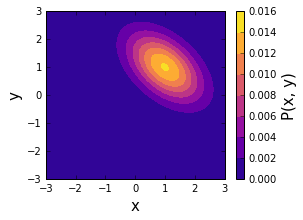

In [14]:
fig, ax = plot_contours(posterior)
#ax.set_title('Posterior for x and y', fontsize=fontsize);
#fig.savefig(path + 'posterior.pdf', bbox_inches='tight')

## Inference tutorial

We first set x and y to -1 to enure that a nice walk.

### Take 10 steps of gradient ascent.

In [15]:
%%venturescript
define get_gradient_mh_walk = () -> {
    reset_to_prior;
    return([
        mapv((i) -> run({
            x  <- sample(x);
            y  <- sample(y);
            grad_ascent(quote(latent), all, 0.01, 1, 1);
            return([x, y])
        }), arange(1000)),
        mapv((i) -> run({
            x  <- sample(x);
            y  <- sample(y);
            mh(default, one, 1);
            return([x, y])
        }), arange(100))
    ])
};

### Plot the walks of the two inference programs onto the posterior

In [16]:
def plot_walk_on_axis(ax, walk, marker, label):
    walk = np.asarray(walk) # Convert list to numpy array for convenient indexing
    ax.plot(
        walk[:,0], #sampled x values
        walk[:,1], #sampled y values
        color='white',
        markersize=7,
        linestyle='--',
        marker=marker,
        label=label,
        markerfacecolor='None',
        markeredgecolor='white',
        markeredgewidth=1.5,
        alpha=0.5
    )
    ax.set_xlim(-bound, bound)
    ax.set_ylim(-bound, bound)
    ax.legend(loc='upper left', fontsize=10, framealpha=0.5)
    return ax

In [17]:
d1 = np.loadtxt('gradient_mh_walk1_i0.csv')
d2 = np.loadtxt('gradient_mh_walk1_i1.csv')
gradient_mh_walk1 = [d1, d2]

In [18]:
fontsize=14

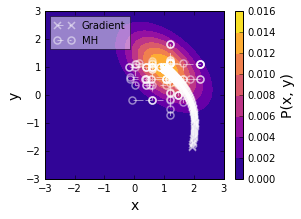

In [19]:
fig, ax = plot_contours(posterior) # Plot the posterior.
# Plot the two walks.
ax = plot_walk_on_axis(ax, gradient_mh_walk1[0], marker='x', label='Gradient')
ax = plot_walk_on_axis(ax, gradient_mh_walk1[1], marker='o', label='MH')
#ax.set_title('Trace example #1', fontsize=fontsize, y=1.01);
#fig.savefig(path + 'traces--1.pdf', bbox_inches='tight')

In [20]:
d1 = np.loadtxt('gradient_mh_walk2_i0.csv')
d2 = np.loadtxt('gradient_mh_walk2_i1.csv')
gradient_mh_walk2 = [d1, d2]

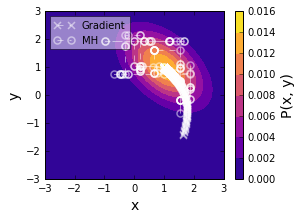

In [21]:
fig, ax = plot_contours(posterior) # Plot the posterior.
# Plot the two walks.
ax = plot_walk_on_axis(ax, gradient_mh_walk2[0], marker='x', label='Gradient')
ax = plot_walk_on_axis(ax, gradient_mh_walk2[1], marker='o', label='MH')
#ax.set_title('Trace example #2', fontsize=fontsize, y=1.01);
#fig.savefig(path + 'traces--2.pdf', bbox_inches='tight')

In [22]:
d1 = np.loadtxt('gradient_mh_walk3_i0.csv')
d2 = np.loadtxt('gradient_mh_walk3_i1.csv')
gradient_mh_walk3 = [d1, d2]

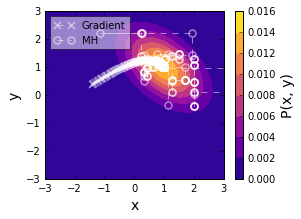

In [23]:
fig, ax = plot_contours(posterior) # Plot the posterior.
# Plot the two walks.
ax = plot_walk_on_axis(ax, gradient_mh_walk3[0], marker='x', label='Gradient')
ax = plot_walk_on_axis(ax, gradient_mh_walk3[1], marker='o', label='MH')
#ax.set_title('Trace example #3', fontsize=fontsize, y=1.01);
#fig.savefig(path + 'traces--3.pdf', bbox_inches='tight')

## Get samples from the (pre-) posterior

In [24]:
%%venturescript
define prior_samples_xy = mapv(
    (i) -> run({
        reset_to_prior;
        x  <- sample(x);
        y  <- sample(y);
        return([x, y])
    }),
    arange(100)
);

### Plot samples

In [25]:
def plot_samples(ax, samples_xy, title, marker):
    if marker == 'o':
        facecolor = 'None'
    else:
        facecolor = 'white'
    samples_xy = np.asarray(samples_xy)
    ax.scatter(
        samples_xy[:,0],
        samples_xy[:,1],
        color='white',
        label='Samples',
        marker=marker,
        edgecolor='white',
        lw=1.5,
        s=50,
        alpha=0.7,
        facecolor=facecolor
    )
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.legend(loc='upper left', framealpha=0.5, fontsize=10)
    #ax.set_title(title, fontsize=fontsize, y=1.01)
    return ax

In [26]:
prior_samples_xy = %venturescript prior_samples_xy

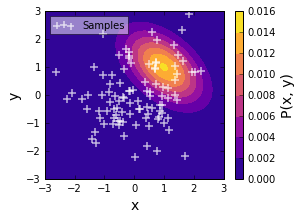

In [27]:
fig, ax = plot_contours(posterior) # Plot the posterior.
ax = plot_samples(ax, prior_samples_xy, title='Samples from the prior', marker='+')
#fig.savefig(path + 'samples-prior.pdf', bbox_inches='tight')

In [28]:
after_gradient_samples_xy = np.loadtxt('after_gradient_samples_xy.csv')
after_gradient_and_mh_samples_xy = np.loadtxt('after_gradient_and_mh_samples_xy.csv')

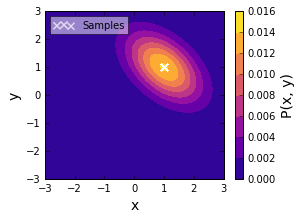

In [29]:
fig, ax = plot_contours(posterior) # Plot the posterior.
ax = plot_samples(ax, after_gradient_samples_xy, title='Samples after gradient steps', marker='x')
#fig.savefig(path + 'samples-gradient.pdf', bbox_inches='tight')

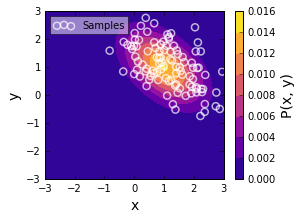

In [30]:
fig, ax = plot_contours(posterior) # Plot the posterior.
ax = plot_samples(ax, after_gradient_and_mh_samples_xy, title='Samples after gradient steps & MH', marker='o')
#fig.savefig(path + 'samples-gradient-mh.pdf', bbox_inches='tight')